 # MTH8408 : Méthodes d'optimisation et contrôle optimal
 ## Projet Lab2
Tangi Migot et Paul Raynaud

In [1]:
using Pkg
Pkg.activate(".") #Accède au fichier Project.toml
Pkg.instantiate()
Pkg.status()
using ADNLPModels, LinearAlgebra, NLPModels, Printf, LDLFactorizations


  Activating project at `C:\Users\Ulrizpascuit\Desktop\MTH8408\MTH8408-Hiv24\lab2`


Status `C:\Users\Ulrizpascuit\Desktop\MTH8408\MTH8408-Hiv24\lab2\Project.toml`
  [54578032] ADNLPModels v0.7.0
  [7073ff75] IJulia v1.24.2
  [40e66cde] LDLFactorizations v0.10.1
  [a4795742] NLPModels v0.20.0
  [5049e819] OptimizationProblems v0.7.3
⌅ [91a5bcdd] Plots v1.39.0
  [37e2e46d] LinearAlgebra
  [de0858da] Printf
  [8dfed614] Test
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


In [2]:
#Amélioration possibles: return also the value of f
function armijo(xk, dk, fk, gk, f)
  slope = dot(gk, dk) #doit être <0
  t = 1.0
  while f(xk + t * dk) > fk + 1.0e-4 * t * slope
    t /= 1.5
  end
  return t
end

armijo (generic function with 1 method)

In [3]:
#SOLUTION: fonction à modifier
function newton_armijo(nlp, x0; verbose::Bool = true)
    t0 = time()
    xk  = x0
    fk  = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = gnorm0 = norm(gk)
    k = 0
    x = [xk]
    verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
    verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100
      Hk = hess(nlp, xk)
      if neval_obj(nlp) > 1000
        println("évaluation de fonctions")
        break
      end
      dk = - Hk \ gk
      slope = dot(dk, gk)
      λ = 0.0
      α = 0
      while slope ≥ -1.0e-4 * norm(dk) * gnorm 
        if α < 5      
          λ = max(1.0e-3, 10 * λ)
          dk = - ((Hk + λ * I ) \ gk)
          slope = dot(dk, gk)
        else
          dk = -gk
          break
        end
      end
      if fk < -1e15
        println("problème non-borné")
        break
      end
      t = armijo(xk, dk, fk, gk, f)
      xk += t * dk
      fk = obj(nlp, xk)
      gk = grad(nlp, xk)
      gnorm = norm(gk)
      k += 1
      push!(x, xk)
      verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
      if time() - t0 > 60
        println("temps")
        break
      end
    end
    if k >= 100
      println("nombre d'itérations")
    end
    return xk,x
end

newton_armijo (generic function with 1 method)

In [4]:
# Solution: modifier le calcul de la direction avec LDLFactorizations
function newton_ldlt_armijo(nlp, x0; verbose::Bool = true)
  xk  = x0
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  x = [xk]
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
    Hk = Symmetric(triu(hess(nlp, xk)), :U)
    Sk = ldl_analyze(Hk)
    ldl_factorize!(Hk, Sk)
    dk = - Sk \ gk
    slope = dot(dk, gk)
    t = armijo(xk, dk, fk, gk, f)
    xk += t * dk
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = norm(gk)
    k += 1
    push!(x, xk)
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  return xk,x
end

newton_ldlt_armijo (generic function with 1 method)

In [5]:
# Solution: copier-coller votre newton_armijo ici et modifier le calcul de la direction avec la méthode de BFGS inverse skip.
function bfgs_quasi_newton_armijo(nlp, x0; verbose::Bool = true)
  xk = x0
  Hk = Matrix(1.0I, length(xk), length(xk))  
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  x = [xk]
    k = 0
    while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
        dk = -Hk * gk  
        alpha = armijo(xk, dk, fk, gk, f)  
        sk = alpha*dk
        xk += sk
        fk_new = obj(nlp, xk)
        gk_new = grad(nlp, xk)
        yk = gk_new - gk
        if yk' * sk > 0
          ρk = 1 / dot(yk, sk)
          Hk = (I - ρk * sk * yk') * Hk * (I - ρk * yk * sk') + ρk * sk * sk'
        end
        fk, gk = fk_new, gk_new
        println("fk: ", fk)
        gnorm = norm(gk)
        k += 1
        push!(x, xk)
    end
    if fk < -1e15
      println("problème non-borné")
    end
    if k==100 
      println("iTER MAX")
    end
  return xk,x
end

bfgs_quasi_newton_armijo (generic function with 1 method)

 ## Exercice 1
1.

In [6]:
# Solution: copier-coller votre newton_armijo ici et modifier le calcul de la direction avec la méthode de BFGS inverse skip.
function bfgs_quasi_newton_quadratic(A , b , x0; verbose::Bool = true)
    xk = x0
    Hk = Matrix(1.0I, length(xk), length(xk))  
    fk = 0.5 * dot(xk, A * xk) - dot(b, xk)
    gk = A * xk - b
    gnorm = gnorm0 = norm(gk)
      k = 0
      while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
          dk = -Hk * gk  
          alpha = -dot(gk, dk) / dot(dk, A * dk)  
          sk = alpha*dk
          xk += sk
          fk_new = 0.5 * dot(xk, A * xk) - dot(b, xk)
          gk_new = A * xk - b
          yk = gk_new - gk
          if yk' * sk > 0
            ρk = 1 / dot(yk, sk)
            Hk = (I - ρk * sk * yk') * Hk * (I - ρk * yk * sk') + ρk * sk * sk'
          end
          fk, gk = fk_new, gk_new
          println("fk: ", fk)
          gnorm = norm(gk)
          k += 1
      end
      if fk < -1e15
        println("problème non-borné")
      end
      if k==100 
        println("iTER MAX")
      end
    return xk
  end

bfgs_quasi_newton_quadratic (generic function with 1 method)

2.

In [7]:
n = 10
A = diagm(-1 => ones(n-1), 0 => 4*ones(n), 1 => ones(n-1))
b = A * [1:n;]

x0 = zeros(n)
result = bfgs_quasi_newton_quadratic(A, b, x0)

fk: -1094.712364783654
fk: -1099.7318145517959
fk: -1099.9821645835452
fk: -1099.9987717514432
fk: -1099.999916019827
fk: -1099.9999943769094
fk: -1099.9999996384386
fk: -1099.99999997879
fk: -1099.9999999990778


10-element Vector{Float64}:
 1.0000185681665295
 1.9999832529289039
 3.0000076415939403
 3.99999710726788
 5.000001001568275
 5.999999670951524
 7.000000104421869
 7.9999999676835385
 9.000000009757585
 9.999999997309164

3.
On veut montrer que $d^T A d >0$. Puisque A est définie positive, alors on a que par définition, $d^T A d$ est strictement positif

 ## Exercice 2

In [8]:
using Plots

In [9]:
x0 = [0.0, 0.0]
f(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
nlp = ADNLPModel(f, x0)

ADNLPModel - Model with automatic differentiation backend ADModelBackend{
  ForwardDiffADGradient,
  ForwardDiffADHvprod,
  EmptyADbackend,
  EmptyADbackend,
  EmptyADbackend,
  ForwardDiffADHessian,
  EmptyADbackend,
}
  Problem name: Generic
   All variables: ████████████████████ 2      All constraints: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            free: ████████████████████ 2                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (  0.00% sparsity)   3               linear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                            

In [10]:
xk_na,x_na = newton_armijo(nlp,x0)
xk_naldl,x_naldl = newton_ldlt_armijo(nlp,x0)
xk_bfgs,x_bfgs = bfgs_quasi_newton_armijo(nlp,x0)

 k        fk ||∇f(x)||
 0  1.70e+02   2.6e+01
 1  1.58e+02   3.8e+01 1.0e+00 
 2  1.34e+02   5.1e+01 1.0e+00 
 3  9.60e+01   6.2e+01 1.0e+00 
 4  6.69e+01   8.8e+01 3.0e-01 
 5  3.78e+01   8.5e+01 2.0e-01 
 6  3.15e+00   1.7e+01 1.0e+00 
 7  1.27e-01   2.9e+00 1.0e+00 
 8  5.10e-04   1.8e-01 1.0e+00 
 9  1.09e-08   8.2e-04 1.0e+00 
10  5.08e-18   1.8e-08 1.0e+00 
 k        fk ||∇f(x)||
 0  1.70e+02   2.6e+01
 1  1.70e+02   2.6e+01 7.2e-16 
 2  1.70e+02   2.6e+01 3.2e-16 
 3  1.70e+02   2.6e+01 1.2e-17 
 4  1.70e+02   2.6e+01 2.8e-20 
 5  1.70e+02   2.6e+01 8.4e-21 
 6  1.70e+02   2.6e+01 2.2e-22 
 7  1.70e+02   2.6e+01 6.5e-23 
 8  1.70e+02   2.6e+01 5.7e-24 
 9  1.70e+02   2.6e+01 1.1e-24 
10  1.70e+02   2.6e+01 3.3e-25 
11  1.70e+02   2.6e+01 9.9e-26 
12  1.70e+02   2.6e+01 1.3e-26 
13  1.70e+02   2.6e+01 1.1e-27 
14  1.70e+02   2.6e+01 3.4e-28 
15  1.70e+02   2.6e+01 3.0e-29 
16  1.70e+02   2.6e+01 5.9e-30 
17  1.70e+02   2.6e+01 5.2e-31 
18  1.70e+02   2.6e+01 1.0e-31 
19  1.70e+02

([3.0000000543990195, 1.9999996348436917], [[0.0, 0.0], [1.8436213991769546, 2.8971193415637857], [2.570158770734812, 3.0930774207795926], [3.4519949381117865, 2.2879435828967436], [2.6887109475508115, 1.9220592807442438], [2.9256472685111135, 2.0185154215535857], [3.0017414961503786, 2.02122901710842], [2.9969472426530794, 2.010091351321117], [2.998749017898697, 2.00161513584304], [2.9998702915112117, 2.0000298211784777], [2.9999959244281196, 1.999993236606497], [3.0000000543990195, 1.9999996348436917]])

([3.0000000543990195, 1.9999996348436917], [[0.0, 0.0], [1.8436213991769546, 2.8971193415637857], [2.570158770734812, 3.0930774207795926], [3.4519949381117865, 2.2879435828967436], [2.6887109475508115, 1.9220592807442438], [2.9256472685111135, 2.0185154215535857], [3.0017414961503786, 2.02122901710842], [2.9969472426530794, 2.010091351321117], [2.998749017898697, 2.00161513584304], [2.9998702915112117, 2.0000298211784777], [2.9999959244281196, 1.999993236606497], [3.0000000543990195, 1.9999996348436917]])

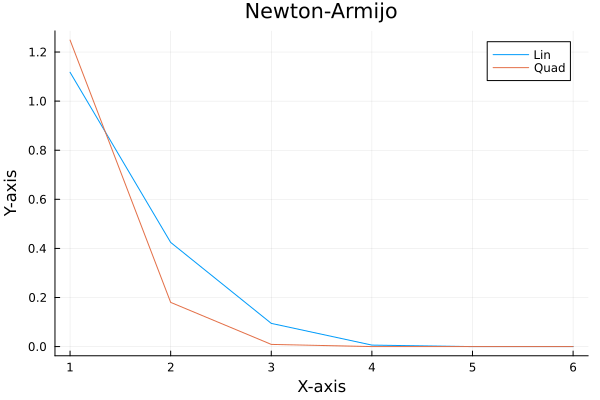

In [11]:
dna_lin=[]
dna_quad=[]
dldl_lin=[]
dldl_quad=[]
dbfgs_lin=[]
dbfgs_quad=[]
for i=1:length(x_na)
    push!(dna_lin, norm(x_na[i]-xk_na))
    push!(dna_quad, norm(x_na[i]-xk_na)^2)
end
for i=1:length(x_naldl)
    push!(dldl_lin, norm(x_naldl[i]-xk_naldl))
    push!(dldl_quad, norm(x_naldl[i]-xk_naldl)^2)
end
for i=1:length(x_bfgs)
    push!(dbfgs_lin, norm(x_bfgs[i]-xk_bfgs))
    push!(dbfgs_quad, norm(x_bfgs[i]-xk_bfgs)^2)
end



plot(1:length(dna_lin[end-5:end]), dna_lin[end-5:end], label="Lin")
plot!(1:length(dna_quad[end-5:end]), dna_quad[end-5:end], label="Quad")
xlabel!("X-axis")
ylabel!("Y-axis")
title!("Newton-Armijo")

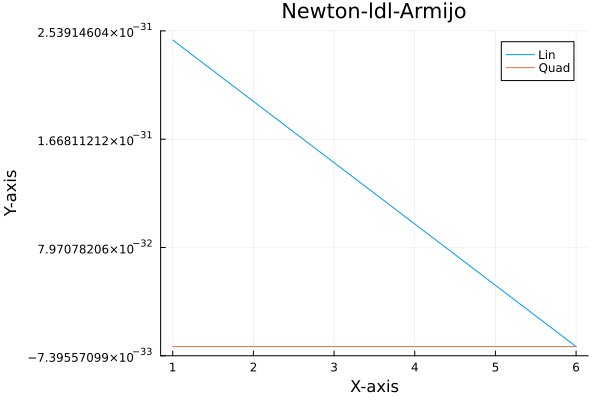

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Ulrizpascuit\.julia\packages\PlotUtils\jEGKP\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Ulrizpascuit\.julia\packages\PlotUtils\jEGKP\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Ulrizpascuit\.julia\packages\PlotUtils\jEGKP\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Ulrizpascuit\.julia\packages\PlotUtils\jEGKP\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Ulrizpascuit\.julia\packages\PlotUtils\jEGKP\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Ulrizpascuit\.julia\packages\PlotUtils\jEGKP\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\Ulrizpascuit\.julia\packages\PlotUtils\jEGKP\src\ticks.jl:191


In [12]:

plot(1:length(dldl_lin[end-5:end]), dldl_lin[end-5:end], label="Lin")
plot!(1:length(dldl_quad[end-5:end]), dldl_quad[end-5:end], label="Quad")
xlabel!("X-axis")
ylabel!("Y-axis")
title!("Newton-ldl-Armijo")

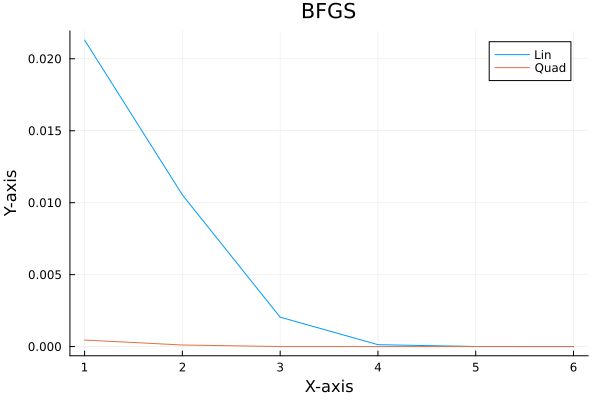

In [13]:
plot(1:length(dbfgs_lin[end-5:end]), dbfgs_lin[end-5:end], label="Lin")
plot!(1:length(dbfgs_quad[end-5:end]), dbfgs_quad[end-5:end], label="Quad")
xlabel!("X-axis")
ylabel!("Y-axis")
title!("BFGS")

Selon les graphiques, l'algorithme newton-ldl-armijo semble avoir un ordre de convergence linéaire, car la courbe Lin a une pente constante. Cependant, les algorithmes newton-armijo et BFGS semblent avoir une convergence superlinéaire puisqu'aucune de leurs deux courbes ont une pente constante (Lin et Quad).